<h1> Line of Balance </h>

<h4> By: Sunghwan Yoon </h4>

<h3>0. Mock Data Generation</h3>

In [ ]:
import csv
import random
from collections import defaultdict

# ---------- Helper Functions ----------
def random_qty(min_qty=50, max_qty=150):
    return random.randint(min_qty, max_qty)

def choose_status(status_list):
    return random.choice(status_list)

# ---------- 1. Company_Inventory ----------
def generate_boeing_inventory(filename="Inventory.csv", num_rows=10):
    with open(filename, "w", newline="") as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["part_number", "qty"])
        for i in range(1, num_rows + 1):
            part_number = f"PN{i:03d}"
            qty = random_qty(50, 300)
            writer.writerow([part_number, qty])
    print(f"Generated {filename}")

# ---------- 2. Company_Line_Demand ----------
def generate_boeing_line_demand(filename="Line_Demand.csv"):
    # We'll use line numbers 100, 101, 102, 103, 104.
    # Rules:
    # - For line 102: exactly 2 distinct part numbers.
    # - For line 104: exactly 3 distinct part numbers.
    # - Other lines: randomly choose between 3 and 5 distinct parts.
    # Then, for each selected (line, part), we simulate 1 or 2 rows (which we later aggregate).
    
    line_numbers = [100, 101, 102, 103, 104]
    parts = [f"PN{i:03d}" for i in range(1, 11)]  # PN001 to PN010
    rows = []  # we'll collect rows as tuples: (line_number, part_number, qty)
    
    for ln in line_numbers:
        if ln == 102:
            num_parts = 2
        elif ln == 104:
            num_parts = 3
        else:
            num_parts = random.randint(3, 5)
        selected_parts = random.sample(parts, num_parts)
        for part in selected_parts:
            # simulate duplicate rows: decide randomly whether to have one row or two rows
            num_rows_for_this = random.choice([1, 2])
            for _ in range(num_rows_for_this):
                qty = random_qty(30, 100)
                rows.append((ln, part, qty))
    
    # Aggregate duplicates: key = (line_number, part_number), value = sum(qty)
    aggregated = defaultdict(int)
    for ln, part, qty in rows:
        aggregated[(ln, part)] += qty

    # Write CSV sorted by line_number then part_number
    with open(filename, "w", newline="") as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["part_number", "line_number", "qty"])
        for (ln, part), total_qty in sorted(aggregated.items(), key=lambda x: (x[0][0], x[0][1])):
            writer.writerow([part, ln, total_qty])
    print(f"Generated {filename}")

# ---------- 3. Supplier ----------
def generate_suppliers(filename="Supplier.csv"):
    suppliers = [
        (1, "Supplier A"),
        (2, "Supplier B"),
        (3, "Supplier C")
    ]
    with open(filename, "w", newline="") as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["supplier_id", "name"])
        for sup in suppliers:
            writer.writerow(sup)
    print(f"Generated {filename}")

# ---------- 4. Supplier_Shipment ----------
def generate_supplier_shipment(filename="Supplier_Shipment.csv", num_rows=50):
    shipment_statuses = ["PACKING", "SHIPPED", "STAGED", "DELIVERED"]
    parts = [f"PN{i:03d}" for i in range(1, 11)]
    
    with open(filename, "w", newline="") as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["id", "supplier_id", "part_number", "qty", "status"])
        for i in range(1, num_rows + 1):
            supplier_id = ((i - 1) % 3) + 1  # cycles 1,2,3
            part_number = random.choice(parts)
            qty = random_qty(50, 150)
            status = choose_status(shipment_statuses)
            writer.writerow([i, supplier_id, part_number, qty, status])
    print(f"Generated {filename}")

# ---------- 5. Supplier_Production_Status ----------
def generate_supplier_production_status(filename="Supplier_Production_Status.csv", num_rows=50):
    production_statuses = ["FINAL_ASSEMBLY", "SUBASSEMBLY", "STAGED"]
    parts = [f"PN{i:03d}" for i in range(1, 11)]
    
    with open(filename, "w", newline="") as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["id", "supplier_id", "part_number", "qty", "status"])
        for i in range(1, num_rows + 1):
            supplier_id = ((i - 1) % 3) + 1  # cycles 1,2,3
            part_number = random.choice(parts)
            qty = random_qty(50, 150)
            status = choose_status(production_statuses)
            writer.writerow([i, supplier_id, part_number, qty, status])
    print(f"Generated {filename}")

# ---------- Main ----------
def main():
    random.seed(42)  # For reproducibility (optional)
    
    generate_boeing_inventory()
    generate_boeing_line_demand()
    generate_suppliers()
    generate_supplier_shipment()
    generate_supplier_production_status()

if __name__ == "__main__":
    main()

Generated Inventory.csv
Generated Line_Demand.csv
Generated Supplier.csv
Generated Supplier_Shipment.csv
Generated Supplier_Production_Status.csv


<h3>1. Environment Setup </h3>

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

<h3>2. Data Preparation </h3>

In [39]:
# 1. Inventory data 
inventory_df = pd.read_csv("Inventory.csv")  # part_number | qty

# 2. Demand data per production line
demand_df = pd.read_csv("Line_Demand.csv")   # part_number | line_number | qty

# 3. Supplier data
supplier_df = pd.read_csv("Supplier.csv")    # supplier_id | name

# 4. Shipment data (used for WIP if status is PACKING or STAGED)
shipment_df = pd.read_csv("Supplier_Shipment.csv")      # id | supplier_id | part_number | qty | status

# 5. Production status log (used for WIP if status != STAGED)
production_df = pd.read_csv("Supplier_Production_Status.csv")       # id | supplier_id | part_number | qty | status


In [40]:
inventory_df.columns = inventory_df.columns.str.lower()
demand_df.columns = demand_df.columns.str.lower()
shipment_df.columns = shipment_df.columns.str.lower()
production_df.columns = production_df.columns.str.lower()

In [41]:
inventory_df.rename(columns={'qty': 'inventory'}, inplace=True)
demand_df.rename(columns={'qty': 'demand_qty'}, inplace=True)

<h3>3. Grouping 'Transit' and 'WIP'</h3>

In [42]:
# Shipment
transit_df = shipment_df[shipment_df['status'].isin(['PACKING', 'STAGED'])].groupby('part_number')['qty'].sum().reset_index(name='transit')

# Production
wip_df = production_df[production_df['status'] != 'STAGED'].groupby('part_number')['qty'].sum().reset_index(name='wip')

<h3>4. Merging Demand, Transit, and WIP to LoB DataFrame</h3>

In [43]:
# Demand
lob_df = demand_df.copy()
lob_df = lob_df.merge(inventory_df, on='part_number', how='left')
lob_df = lob_df.merge(transit_df, on='part_number', how='left')
lob_df = lob_df.merge(wip_df, on='part_number', how='left')
lob_df['inventory'] = lob_df['inventory'].fillna(0)
lob_df['transit'] = lob_df['transit'].fillna(0)
lob_df['wip'] = lob_df['wip'].fillna(0)

<h3>5. LoB Calculation</h3>

In [44]:
lob_df['total_supply'] = lob_df['inventory'] + lob_df['transit'] + lob_df['wip']
lob_df['surplus'] = lob_df['total_supply'] - lob_df['demand_qty']

In [45]:
lob_df

,part_number,line_number,demand_qty,inventory,transit,wip,total_supply,surplus
0,PN001,100,145,213,206.0,145,564.0,419.0
1,PN002,100,94,78,370.0,366,814.0,720.0
2,PN007,100,55,107,74.0,107,288.0,233.0
3,PN008,100,80,85,0.0,390,475.0,395.0
4,PN009,100,57,238,478.0,265,981.0,924.0
5,PN002,101,143,78,370.0,366,814.0,671.0
6,PN005,101,98,120,181.0,576,877.0,779.0
7,PN006,101,117,112,64.0,370,546.0,429.0
8,PN007,101,84,107,74.0,107,288.0,204.0
9,PN010,101,140,76,219.0,122,417.0,277.0


In [49]:
lob_df['line_number'] = lob_df['line_number'].astype(int)
pivot_demand = lob_df.pivot_table(index='part_number', columns='line_number', values='demand_qty', fill_value=0)
pivot_demand

line_number,100,101,102,103,104
part_number,,,,,
PN001,145,0,0,0,0
PN002,94,143,0,164,0
PN003,0,0,0,0,59
PN004,0,0,0,77,71
PN005,0,98,38,0,0
PN006,0,117,59,0,0
PN007,55,84,0,0,0
PN008,80,0,0,0,0
PN009,57,0,0,51,142


<h3>6. LoB Visualization</h3>

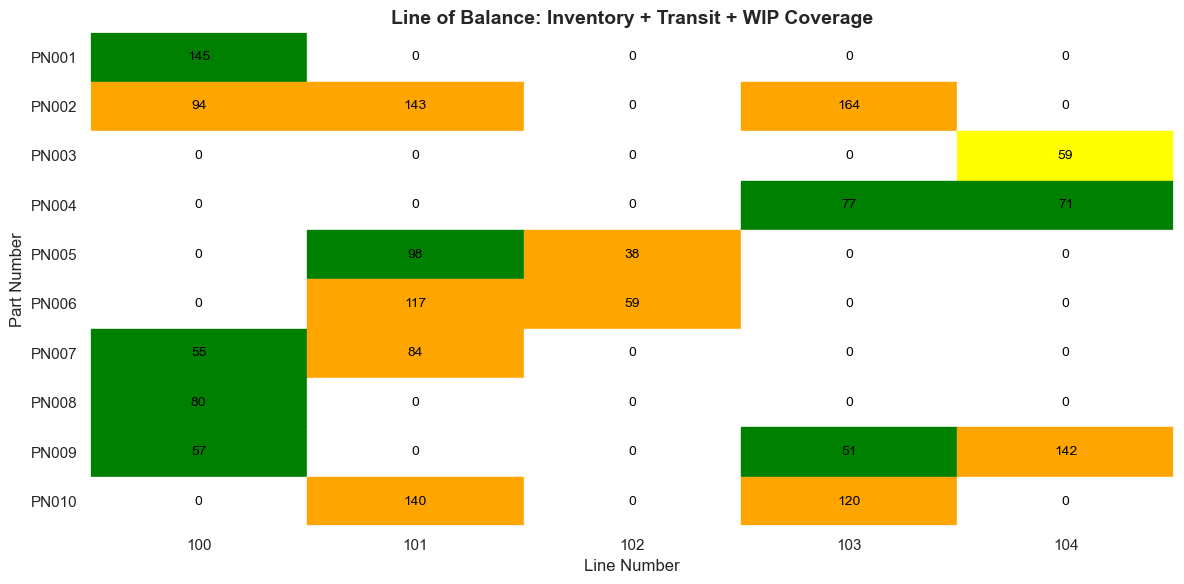

In [52]:
# Supply info
supply_info = lob_df.groupby('part_number')[['inventory', 'transit', 'wip']].first()

# Build color matrix
color_matrix = pd.DataFrame(index=pivot_demand.index, columns=pivot_demand.columns)
for part in pivot_demand.index:
    inventory = supply_info.loc[part, 'inventory']
    transit = supply_info.loc[part, 'transit']
    wip = supply_info.loc[part, 'wip']
    for line in sorted(pivot_demand.columns):
        demand = pivot_demand.loc[part, line]
        if demand == 0:
            color_matrix.loc[part, line] = 'white'
        elif demand <= inventory:
            color_matrix.loc[part, line] = 'green'
            inventory -= demand
        elif demand <= inventory + transit:
            color_matrix.loc[part, line] = 'orange'
            transit -= max(0, demand - inventory)
            inventory = 0
        elif demand <= inventory + transit + wip:
            color_matrix.loc[part, line] = 'yellow'
            wip -= max(0, demand - inventory - transit)
            transit = 0
            inventory = 0
        else:
            color_matrix.loc[part, line] = 'red'

# Draw grid
fig, ax = plt.subplots(figsize=(12, 6))
for y, part in enumerate(color_matrix.index):
    for x, line in enumerate(color_matrix.columns):
        color = color_matrix.loc[part, line]
        text = pivot_demand.loc[part, line]
        ax.add_patch(plt.Rectangle((x, y), 1, 1, color=color))
        ax.text(x + 0.5, y + 0.5, str(text), ha='center', va='center', color='black', fontsize=10)

# Axis formatting
ax.set_xlim(0, len(color_matrix.columns))
ax.set_ylim(0, len(color_matrix.index))
ax.set_xticks([i + 0.5 for i in range(len(color_matrix.columns))])
ax.set_xticklabels(color_matrix.columns)
ax.set_yticks([i + 0.5 for i in range(len(color_matrix.index))])
ax.set_yticklabels(color_matrix.index)
ax.invert_yaxis()
ax.set_xlabel("Line Number")
ax.set_ylabel("Part Number")
ax.set_title("Line of Balance: Inventory + Transit + WIP Coverage", fontsize=14, weight='bold')
plt.grid(False)
plt.tight_layout()
plt.show()